# Logistic Regression

## Importing Processed Dataset

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/Users/svr/Desktop/DSBA/NLP/FINAL/IMDB Dataset proccessed.csv')
data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production filming technique ...,1
2,I think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Data Split

Class counter (stratified):
Entire-set  : Counter({1: 25000, 0: 25000}).
Train-set   : Counter({1: 20000, 0: 20000}).
Test-set    : Counter({0: 5000, 1: 5000}).


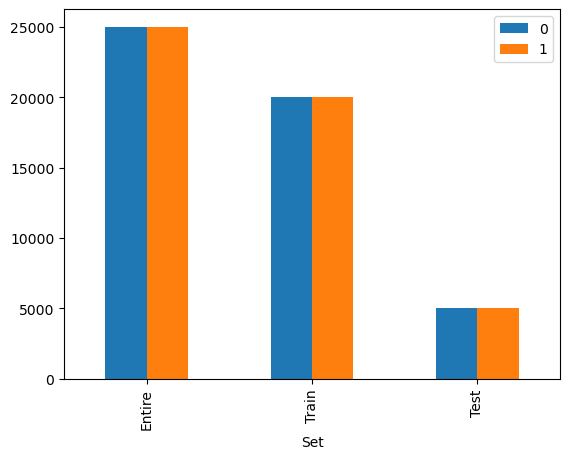

In [3]:
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold

# Randomness to reproduce same splits for comparisons.
random_state = 42

# K-fold split for cv.
kfold_n_split = 5

# K-fold shuffle for cv.
kfold_shuffle = True

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits=kfold_n_split,
                          shuffle=kfold_shuffle,
                          random_state=random_state)

# Define features (X) and target (y)
X = data["review"]  # Use processed text column
y = data["sentiment"]  # Target labels (0 or 1)

train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Split dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(y_train)}.')
print(f'Test-set    : {Counter(y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(y_train).get(0), Counter(y_train).get(1)],
              ['Test', Counter(y_test).get(0), Counter(y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

# TF-IDF Vectorization (Feature Extraction)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.
# Limits the max words used for building the model.
max_features = 50000

# TODO: Afif, please confirm and justify!
# Initialize TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=max_features)
#vectoriser = TfidfVectorizer(ngram_range=(1, 2))

# Fit TF-IDF on cleaned training data
vectoriser.fit(X_train)

print('Vectoriser fitted.')
print('No. of feature words:', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature words: 50000


In [5]:
# Apply transformation to convert text to TF-IDF vectors
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print('Data Transformed.')


Data Transformed.


# Base Random Forest

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state) 

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted for class imbalance
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Accuracy: 0.8585
✅ Precision: 0.8585
✅ Recall: 0.8585
✅ F1-score: 0.8585

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# Base Model Confusion Matrics


🔹 Confusion Matrix:
[[4290  710]
 [ 705 4295]]


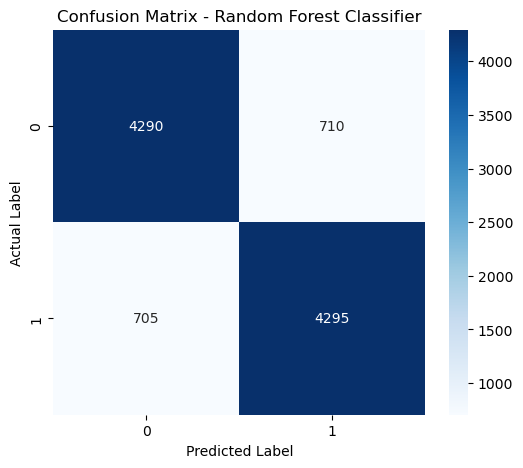

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Get unique class labels dynamically
class_labels = np.unique(y_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


# Random Forest Hyper Parameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Use bootstrapping or not
}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid, scoring='accuracy', cv=skfolds, n_jobs=-1, verbose=1)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_rf = grid_search.best_estimator_

# Make predictions using the best model
y_pred_best = best_rf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Print results
print(f"✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# Print classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
✅ Accuracy: 0.8662
✅ Precision: 0.8662
✅ Recall: 0.8662
✅ F1-score: 0.8662

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5000
           1       0.86      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Tuned Model Confusion Matrics


🔹 Confusion Matrix:
[[4303  697]
 [ 641 4359]]


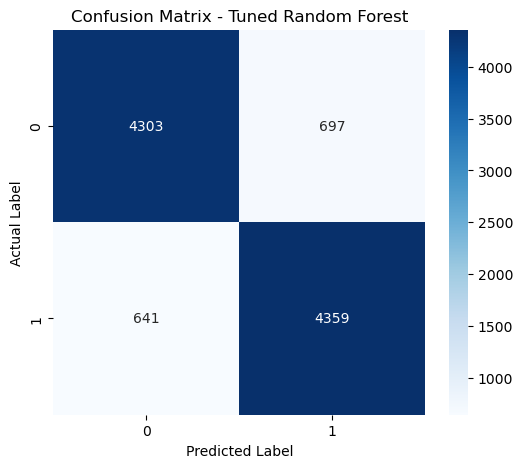

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Get unique class labels dynamically
class_labels = np.unique(y_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()


## ROC Curve

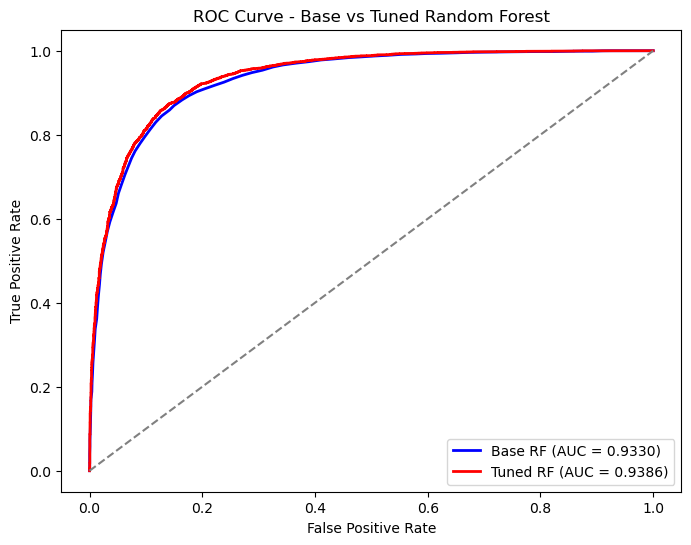

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for ROC curve
y_prob_base = rf_classifier.predict_proba(X_test)[:, 1]  # Base model
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]  # Tuned model

# Compute ROC curve and AUC for base model
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

# Compute ROC curve and AUC for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color='blue', lw=2, label=f'Base RF (AUC = {roc_auc_base:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned RF (AUC = {roc_auc_tuned:.4f})')

# Random classifier line (baseline)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels and Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Base vs Tuned Random Forest')
plt.legend(loc='lower right')
plt.show()


# Save Best Model into Pickle

### We will save the trained and tuned model into pickle file so it can be deployed later.

In [ ]:
# Save the model into pickle file.
pickle.dump(best_rf, open(pickle_ml_model_path, 'wb'))

In [ ]:
# Load the model to verification.
loaded_rf = pickle.load(open(pickle_ml_model_path, 'rb'))
result = loaded_rf.score(X_test, y_test)
print(result)